In [1]:
# To be able to make edits to repo without having to restart notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, mannwhitneyu, wilcoxon, ttest_rel, ttest_ind
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ColorConverter

PROJECT_PATH = os.getcwd()
sys.path.append(PROJECT_PATH)

In [3]:
# ANT_path = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\LEC_remapping\ANT"
# NON_path = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\LEC_remapping\NON"
# B6_path = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\LEC_remapping\B6"
# dfs = []
# for path in [ANT_path, NON_path, B6_path]:
#     for animal_dir in os.listdir(path):
#         for csv_file in os.listdir(path + r'\\' + animal_dir):
#             if csv_file.endswith('.xlsx'):
#                 file_df = pd.read_excel(path + r'\\' + animal_dir + r'\\' + csv_file)
#                 # add column for genotype
#                 if path == ANT_path:
#                     file_df['group'] = 'ANT'
#                 elif path == NON_path:
#                     file_df['group'] = 'NON'
#                 elif path == B6_path:
#                     file_df['group'] = 'B6'
#                 dfs.append(file_df)

# df = pd.concat(dfs, ignore_index=True)

df = pd.read_excel(r'C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\LEC_full_merged_scores.xlsx')
# df = df[df['information'] >= 0.25]

In [4]:
df.columns 

Index(['Unnamed: 0.2', 'Unnamed: 0', 'signature', 'depth', 'name', 'date',
       'tetrode', 'unit_id', 'session_id', 'obj_pos', 'object_location',
       'score', 'field_id', 'field_count', 'obj_wass_0', 'obj_wass_90',
       'obj_wass_180', 'obj_wass_270', 'obj_wass_NO', 'obj_q_0', 'obj_q_90',
       'obj_q_180', 'obj_q_270', 'obj_q_NO', 'obj_vec_0', 'obj_vec_90',
       'obj_vec_180', 'obj_vec_270', 'obj_vec_NO', 'bin_area', 'total_rate',
       'field_peak_rate', 'spike_count', 'field_coverage', 'field_area',
       'field_rate', 'cumulative_coverage', 'cumulative_area',
       'cumulative_rate', 'arena_size', 'cylinder', 'ratemap_dims', 'spacing',
       'hexagonal', 'sample_size', 'downsample_factor', 'group',
       'Unnamed: 0.1', 'Session', 'Tetrode', 'Cell ID', 'spike_width',
       'spike_count.1', 'firing_rate', 'Avg. Spikes/Burst', 'bursting',
       'iso_dist', 'L_ratio', 'ISI_min', 'ISI_max', 'ISI_mean', 'ISI_median',
       'ISI_cv', 'ISI_std', 'sparsity', 'selectivity'

In [5]:
""" FILTERING """

""" REMOVE FIELD WITH LOW COVERAGE % """
# remove rows with field_coverage < 0.1
# df = df[df['field_coverage'] >= 0.1]

""" ONLY KEEPING MAIN FIELD """
# remove rows where field_id is not 1 and score is not 'whole' or 'spike_density'
# df = df[(df['field_id'] == 1) | (df['score'] == 'whole') | (df['score'] == 'spike_density')]

""" CHOOSING MIN ANGLE FOR EACH ROW """
# for each row, choose lowest quantile from ['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270']
df['obj_q'] = df[['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270']].min(axis=1)
df['obj_a'] = df[['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270']].idxmin(axis=1)
# convert obj_a to degrees
df['obj_a'] = df['obj_a'].apply(lambda x: int(x.split('_')[2]))
# use obj_wass with angle of min quantile
df['obj_w'] = df.apply(lambda x: x['obj_wass_' + str(x['obj_a'])], axis=1)

df = df[df['iso_dist'] > 5]


In [6]:
df.columns

Index(['Unnamed: 0.2', 'Unnamed: 0', 'signature', 'depth', 'name', 'date',
       'tetrode', 'unit_id', 'session_id', 'obj_pos', 'object_location',
       'score', 'field_id', 'field_count', 'obj_wass_0', 'obj_wass_90',
       'obj_wass_180', 'obj_wass_270', 'obj_wass_NO', 'obj_q_0', 'obj_q_90',
       'obj_q_180', 'obj_q_270', 'obj_q_NO', 'obj_vec_0', 'obj_vec_90',
       'obj_vec_180', 'obj_vec_270', 'obj_vec_NO', 'bin_area', 'total_rate',
       'field_peak_rate', 'spike_count', 'field_coverage', 'field_area',
       'field_rate', 'cumulative_coverage', 'cumulative_area',
       'cumulative_rate', 'arena_size', 'cylinder', 'ratemap_dims', 'spacing',
       'hexagonal', 'sample_size', 'downsample_factor', 'group',
       'Unnamed: 0.1', 'Session', 'Tetrode', 'Cell ID', 'spike_width',
       'spike_count.1', 'firing_rate', 'Avg. Spikes/Burst', 'bursting',
       'iso_dist', 'L_ratio', 'ISI_min', 'ISI_max', 'ISI_mean', 'ISI_median',
       'ISI_cv', 'ISI_std', 'sparsity', 'selectivity'

In [ ]:
# for i, row in df.iterrows():
#     row['field_rate'] = row['field_rate'] * row['bin_area'] / ((eval(df['ratemap_dims'][0])[0])**2 * row['bin_size'])

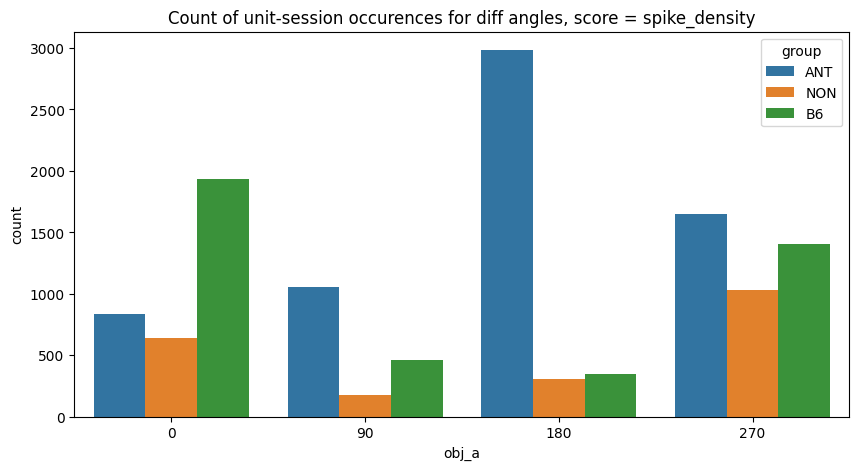

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warni

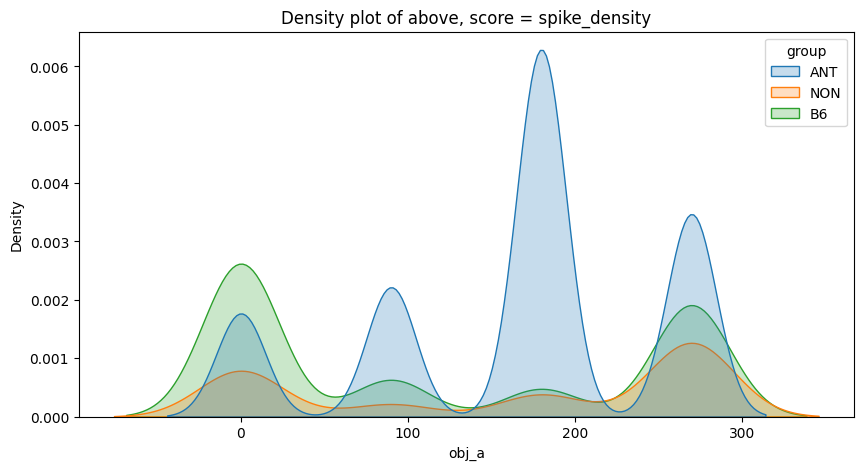

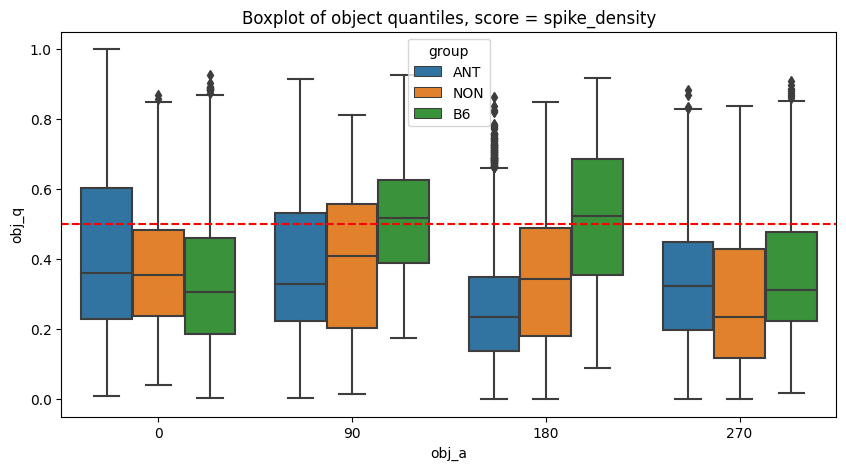

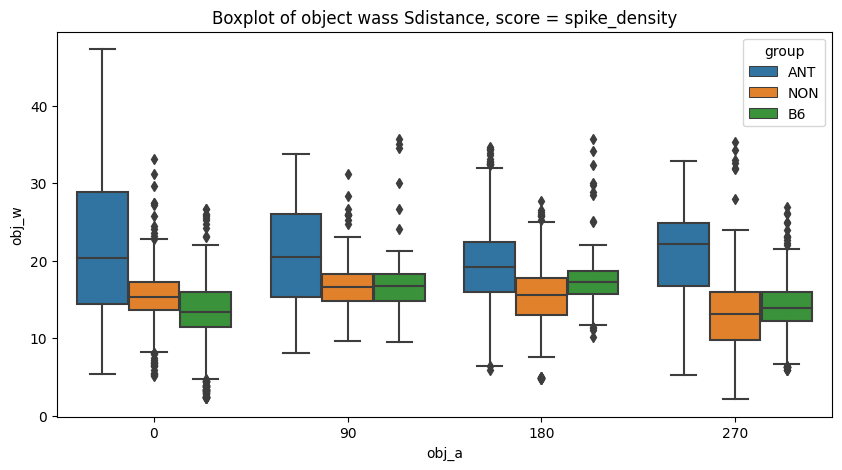

In [7]:

# only accept obj_q if it is less than 0.05
# df_to_use = df[df['obj_q'] < 0.05]
# only use one score
df_to_use = df
score = 'spike_density'
df_to_use = df_to_use[df_to_use['score'] == score]
# df_to_use = df_to_use[df_to_use['field_count'] == 1]
# only accept if obj_a == object_location
# df_to_use = df_to_use[df_to_use['obj_a'] == df_to_use['object_location']]
# count appearance of each object_location for each group

# only session_1
# df_to_use = df_to_use[df_to_use['session_id'] == 'session_1']

# average quantiles for each cell 
# df_to_use = df_to_use.groupby(['name', 'group', 'tetrode','unit_id', 'field_id', 'object_location', 'obj_a', 'score']).mean().reset_index()
# df_to_use = df_to_use[df_to_use['obj_q'] < 0.05]


# figure with 4 boxplots in one plot 
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='obj_a', hue='group', data=df_to_use, ax=ax)
plt.title('Count of unit-session occurences for diff angles, score = ' + score)
plt.show()


fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(x='obj_a', hue='group', data=df_to_use, ax=ax, fill=True)
plt.title('Density plot of above, score = ' + score)
plt.show()

# boxplot
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='obj_a', y='obj_q', hue='group', data=df_to_use, ax=ax)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('Boxplot of object quantiles, score = ' + score)
plt.show()

# boxplot
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='obj_a', y='obj_w', hue='group', data=df_to_use, ax=ax)
plt.title('Boxplot of object wass Sdistance, score = ' + score)
plt.show()


# plt.show() 


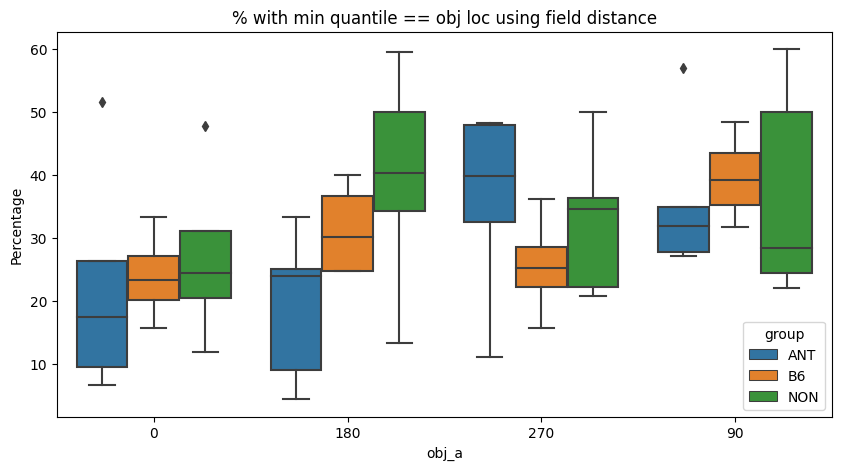

In [8]:
df['obj_a'] = df['obj_a'].astype(str)
# df_to_use = df[df['field_count'] == 1]
score = 'field'

group_by = ['object_location', 'group', 'name'] # unique animals_group_angle
# group_by = ['object_location', 'group', 'name','tetrode', 'session_id'] # unique animal tetrode sessions 
# group_by = ['object_location', 'group'] # unique group_angles
# group_by = ['object_location', 'group', 'name','session_id'] # unique animal sessions
# group_by = ['object_location', 'group', 'name','tetrode', 'unit_id', 'date'] # unique animal sessions
# group_by = ['depth', 'name', 'date', 'tetrode', 'object_location', 'group'] # unique sessions for a cell

# average by neuron
# group_by = ['object_location', 'group', 'name', 'depth', 'date','tetrode', 'unit_id']
# average by session
# group_by = ['object_location','group', 'name', 'depth', 'date','stim','session_id']

df_to_use = df[df['score'] == score]
# Calculate the total count for each angle and group
total_count = df_to_use.groupby(group_by).size().reset_index(name='total_count')
# Filter rows where obj_a is equal to object_location
df_to_use = df_to_use[df_to_use['obj_a'] == df_to_use['object_location']]
# Calculate the count for each angle and group
count = df_to_use.groupby(group_by).size().reset_index(name='count')
# Merge count and total_count
df_to_use = count.merge(total_count, on=group_by)
# Calculate the percentage
df_to_use['percentage'] = df_to_use['count'] / df_to_use['total_count'] * 100
# df_to_use = df_to_use.groupby(['name', 'group', 'tetrode','unit_id', 'field_id', 'object_location', 'obj_a', 'score']).mean().reset_index()

# Plot the percentage as a bar plot
fig, ax = plt.subplots(figsize=(10, 5))
# sns.barplot(x='object_location', y='percentage', hue='group', data=df_to_use, ax=ax)
# boxplot
sns.boxplot(x='object_location', y='percentage', hue='group', data=df_to_use, ax=ax)
# sns.swarmplot(x='object_location', y='percentage',color='black', data=df_to_use, ax=ax)
# sns.barplot(x='group', y='percentage', data=df_to_use, ax=ax)
plt.title('% with min quantile == obj loc using ' + score + ' distance')
plt.xlabel('obj_a')
plt.ylabel('Percentage')
plt.show()

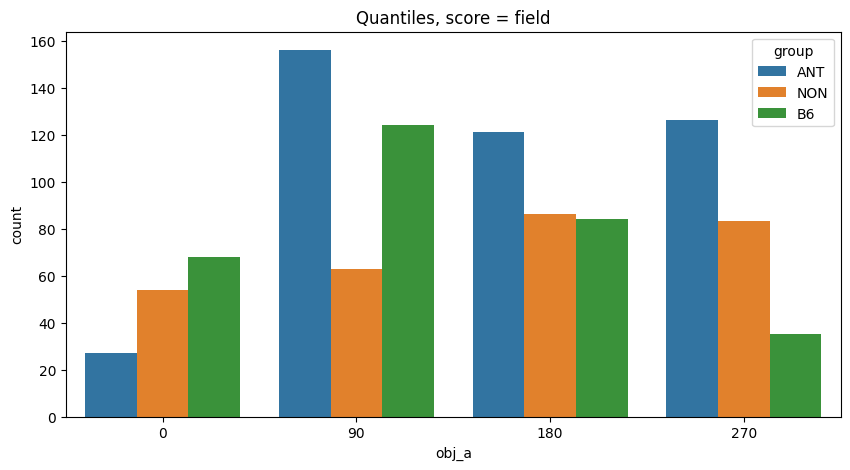

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warni

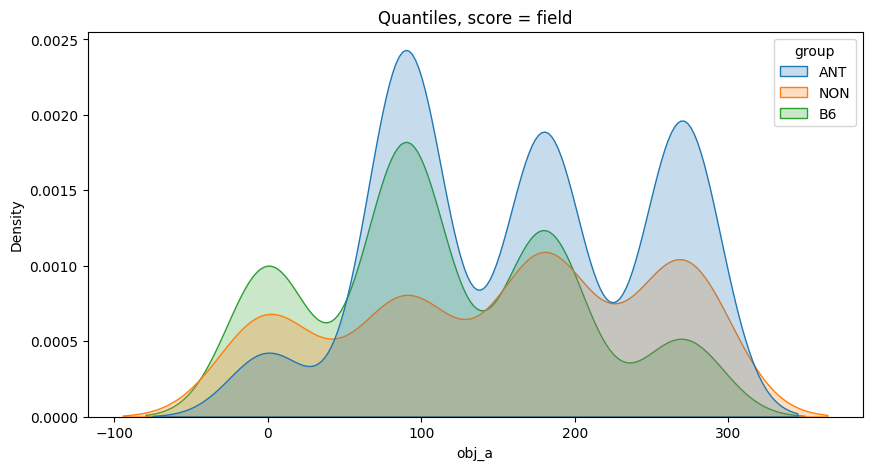

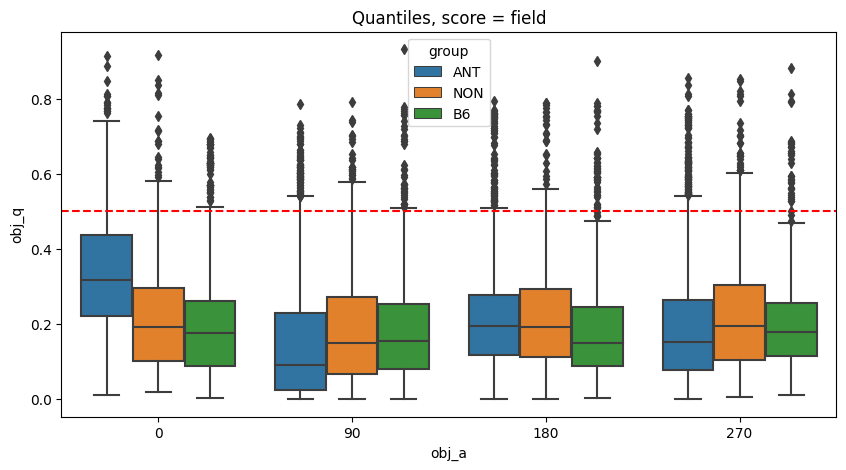

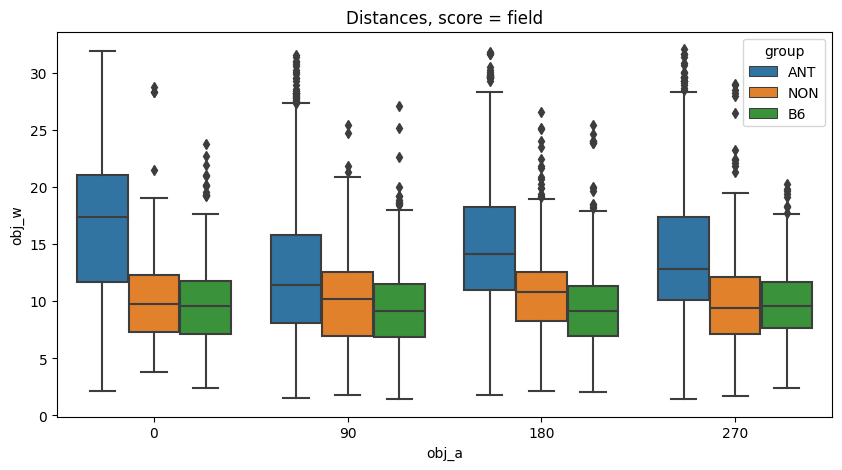

In [9]:
# df_to_use = df[df['obj_q'] < 0.05]
df['obj_a'] = df['obj_a'].astype(int)
df_to_use = df
score = 'field'
df_to_use = df_to_use[df_to_use['score'] == score]

groups = df_to_use.groupby(['depth', 'name', 'date', 'tetrode', 'group'])

# Step 3: Custom function to filter based on previous session's object angle
def filter_previous_session(group):
    filtered_rows = []

    previous_session_location = None
    previous_session_count = None

    for _, row in group.iterrows():
        current_session_location = row['object_location']
        session_id = row['session_id']

        # Extract session count from session_id
        session_count = int(session_id.split('_')[1])

        if previous_session_location is not None and session_count > 1:
            if session_count - 1 == previous_session_count:
                previous_session = group[group['session_id'] == f'session_{previous_session_count}']
                previous_session_location = previous_session['object_location'].values[0]

                if str(row['obj_a']) == previous_session_location:
                    filtered_rows.append(row)

        previous_session_location = current_session_location
        previous_session_count = session_count

    return pd.DataFrame(filtered_rows)

# Step 4: Apply custom function to each group and concatenate results
filtered_data = pd.concat([filter_previous_session(group) for _, group in groups])

# drop session_2 
# filtered_data = filtered_data[filtered_data['session_id'] != 'session_2']

# filtered_data = filtered_data.groupby(['name', 'group', 'object_location','obj_a','tetrode','unit_id']).mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='obj_a', hue='group', data=filtered_data, ax=ax)
plt.title('Quantiles, score = ' + score)
plt.show()


fig, ax = plt.subplots(figsize=(10, 5))
df['obj_a'] = df['obj_a'].astype(int)
sns.kdeplot(x='obj_a', hue='group', data=filtered_data, ax=ax, fill=True)
plt.title('Quantiles, score = ' + score)
plt.show()

# boxplot
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='obj_a', y='obj_q', hue='group', data=df_to_use, ax=ax)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title('Quantiles, score = ' + score)
plt.show()

# boxplot
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='obj_a', y='obj_w', hue='group', data=df_to_use, ax=ax)
plt.title('Distances, score = ' + score)
plt.show()



c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warni

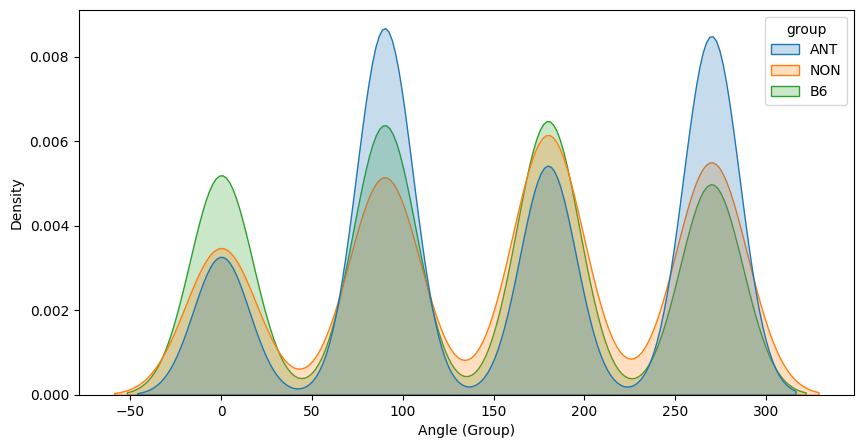

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))

# Density plots
sns.kdeplot(data=df_to_use, x='obj_a', hue='group', fill=True, common_norm=False, ax=ax)

# plt.title('Density Plot - Quantiles < 0.05, score = ' + score)
plt.xlabel('Angle (Group)')
plt.ylabel('Density')

plt.show()


In [11]:
obj_q_keys = ['obj_q_0', 'obj_q_90', 'obj_q_180', 'obj_q_270']
obj_wass_keys = ['obj_wass_0', 'obj_wass_90', 'obj_wass_180', 'obj_wass_270']
obj_vec_keys = ['obj_vec_0', 'obj_vec_90', 'obj_vec_180', 'obj_vec_270']
score_keys = ['whole', 'field', 'binary', 'centroid', 'spike_density']
field_keys = ['field_peak_rate', 'field_coverage', 'field_area', 'field_rate']

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu

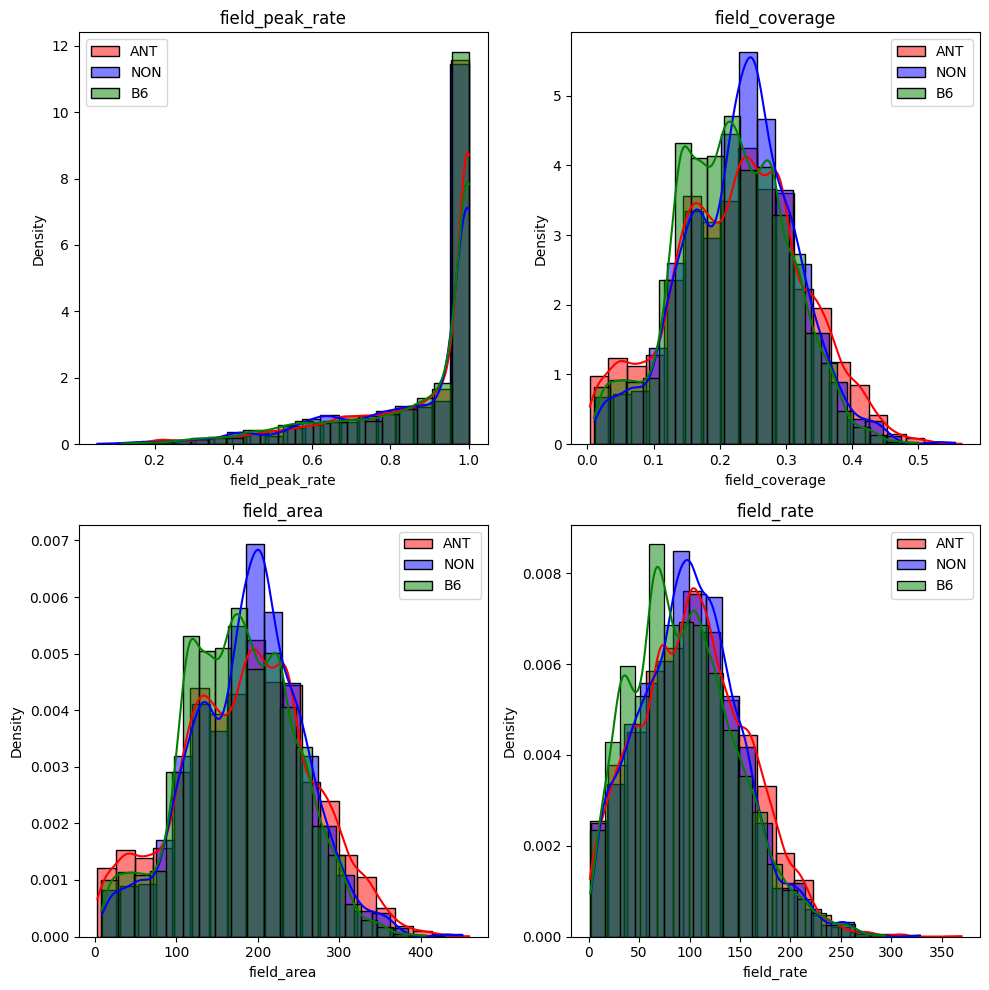

In [12]:
fig = plt.figure(figsize=(10,10))
keys = field_keys
colors = ['red', 'blue', 'green']

for i, key in enumerate(keys):
    ax = fig.add_subplot(2,2,i+1)
    for j, group in enumerate(df.group.unique()):
        to_plot = df[df.group == group][key]
        sns.histplot(to_plot, ax=ax, kde=True, stat='density', bins=20, color=colors[j], alpha=0.5, label=group)

    ax.legend()
    ax.set_title(key)
fig.tight_layout()
plt.show()

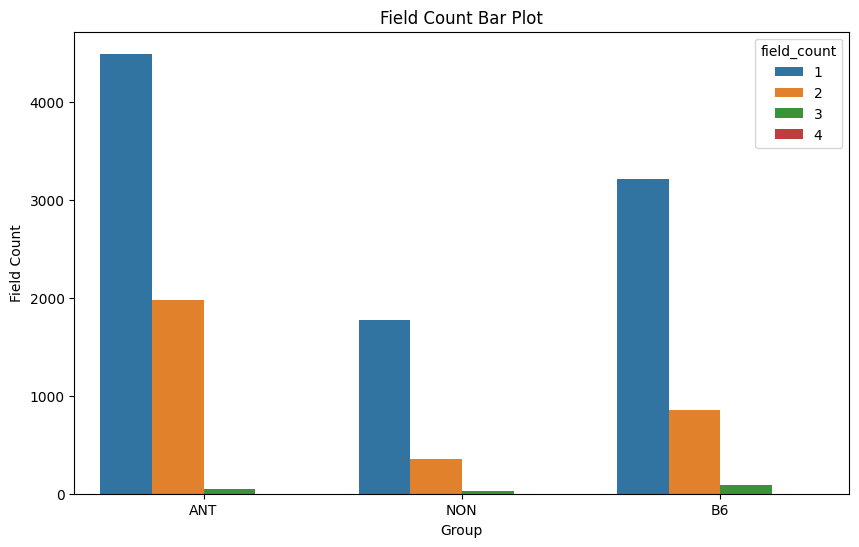

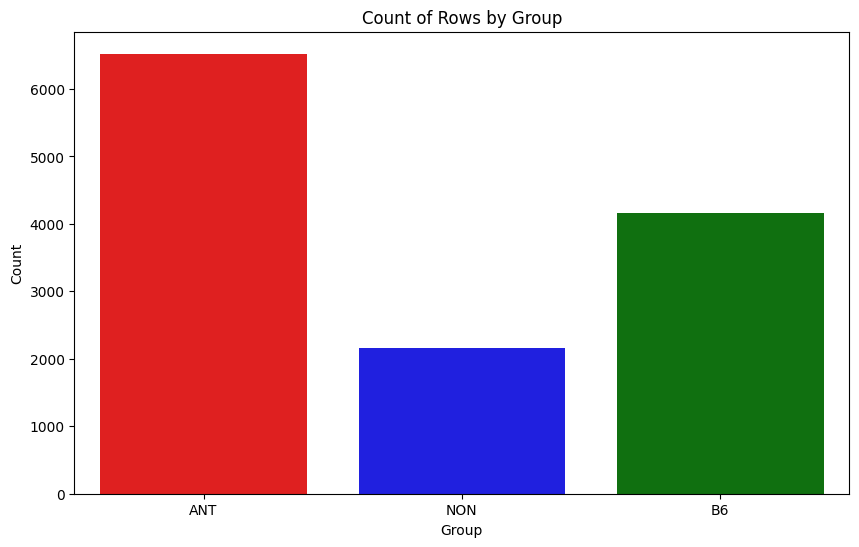

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

to_plot = df[df['score'] == 'whole']
sns.countplot(x='group', hue='field_count', data=to_plot, ax=ax)

ax.set_title('Field Count Bar Plot')
ax.set_xlabel('Group')
ax.set_ylabel('Field Count')

plt.show()


fig, ax = plt.subplots(figsize=(10, 6))

sns.countplot(x='group', data=to_plot, palette=['red','blue','green'], ax=ax)

ax.set_title('Count of Rows by Group')
ax.set_xlabel('Group')
ax.set_ylabel('Count')

plt.show()




c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu

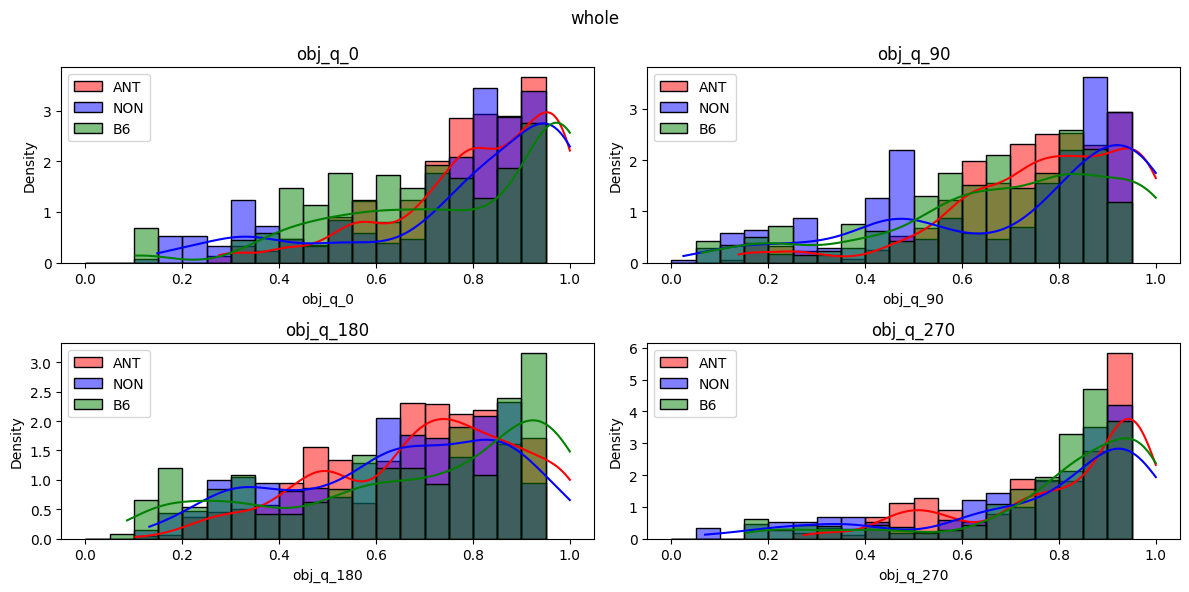

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu

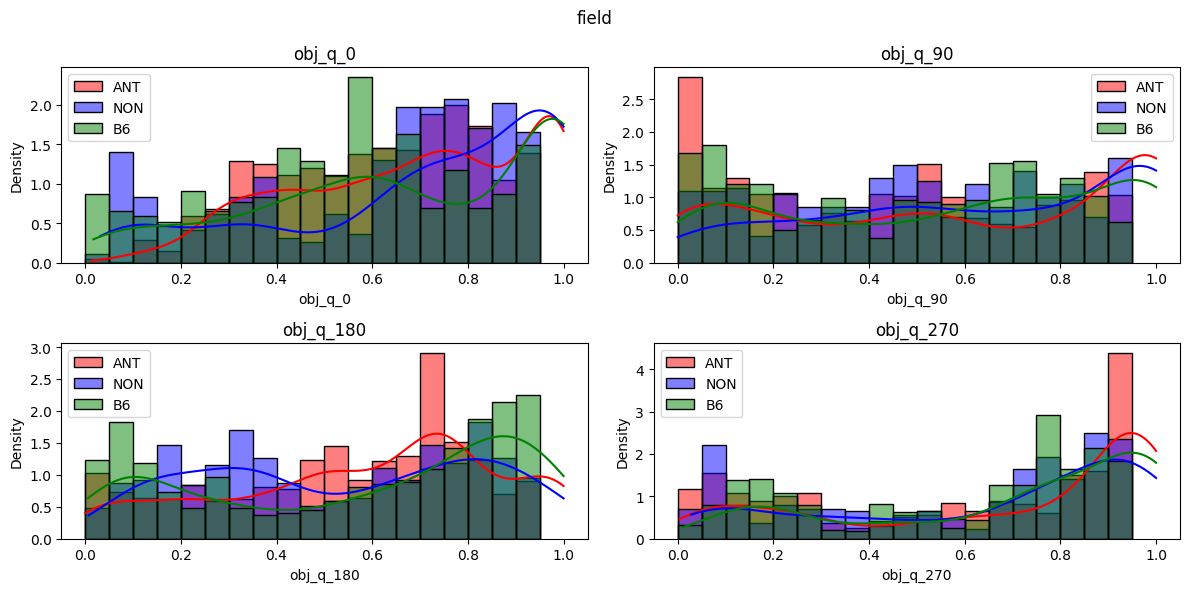

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu

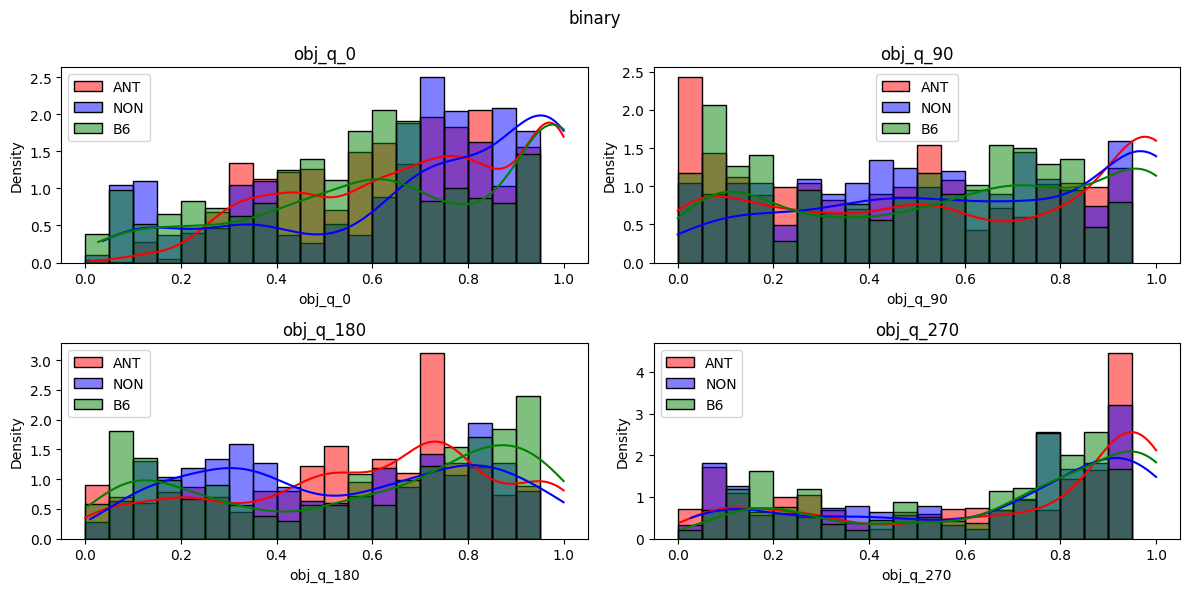

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu

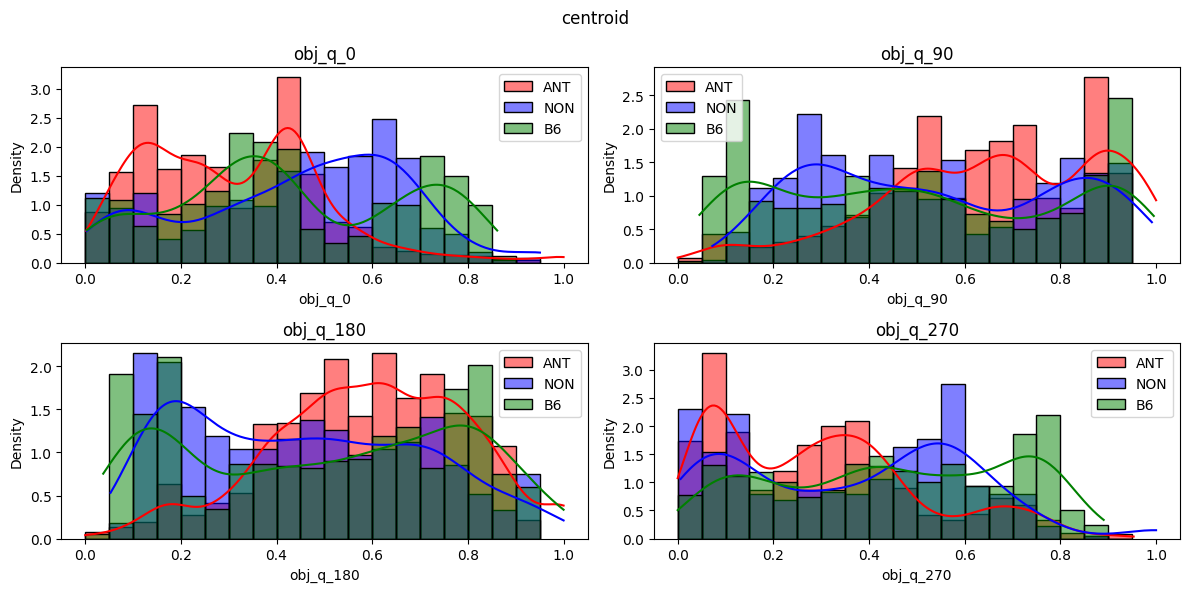

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu

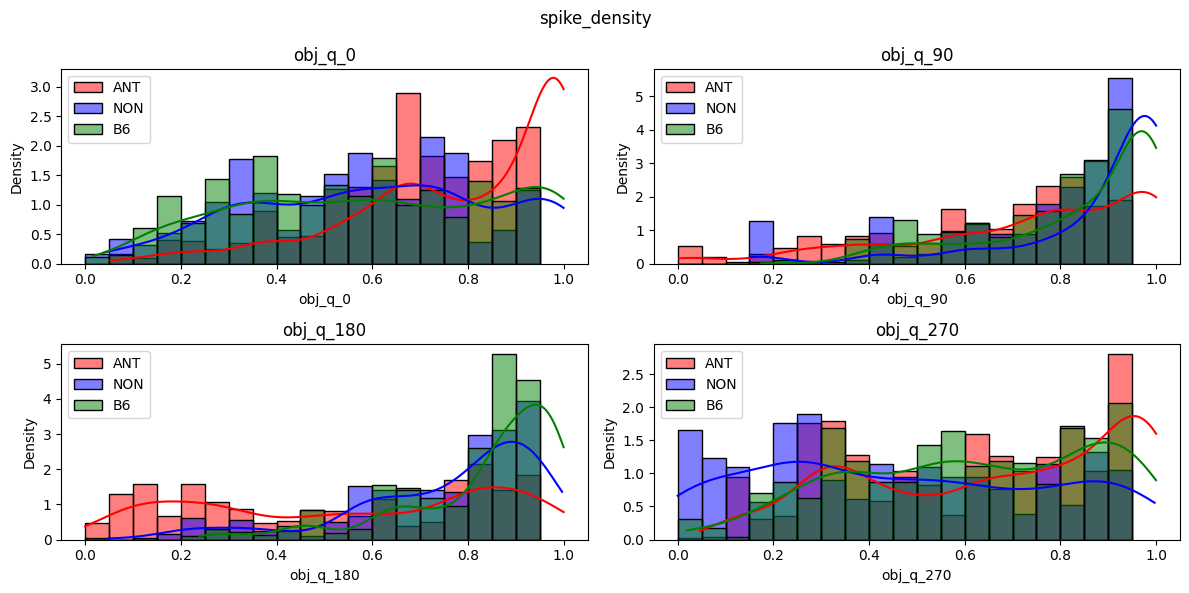

In [14]:
for score in score_keys:
    fig = plt.figure(figsize=(12,6))
    ax = plt.subplot(1,1,1)
    keys = obj_q_keys
    colors = ['red', 'blue', 'green']

    for j in range(1,len(df['group'].unique())+1):
        df_to_plot = df[df['group'] == df['group'].unique()[j-1]]
        df_to_plot = df_to_plot[df_to_plot['session_id'] == 'session_3']

        for i in range(len(keys)):
            to_plot = df_to_plot[keys[i]]
            to_plot = to_plot[df_to_plot['score'] == score]

            ax = plt.subplot(2,2,i+1)
            sns.histplot(to_plot, ax=ax, kde=True, stat='density', bins=np.arange(0,1,1/20), color=colors[j-1], alpha=0.5, label=df['group'].unique()[j-1])
        
            title = df['group'].unique()[j-1] + " " + score + " " + keys[i]
            ax.set_title(keys[i])
            ax.legend()
    fig.suptitle(score)
    fig.tight_layout()
    plt.show()

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\Envs\envPRISM\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aaoun\OneDrive - cumc.columbia.edu

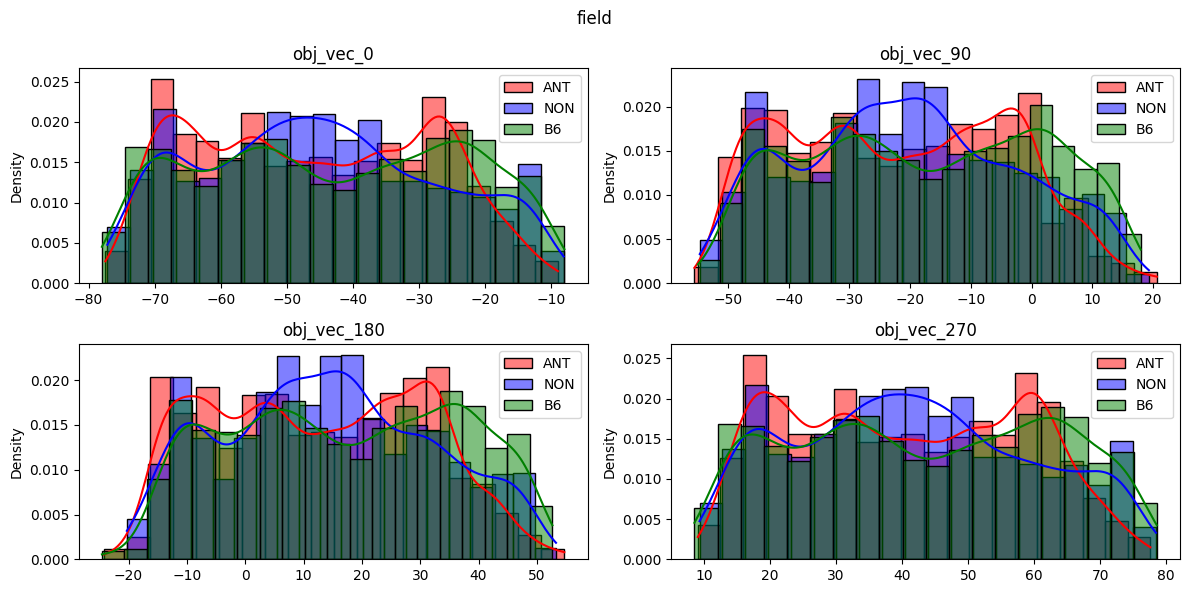

In [18]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1)

score = 'field'
keys = obj_vec_keys
mag_or_angle = 'angle'
colors = ['red', 'blue', 'green']

for j in range(1,len(df['group'].unique())+1):
    df_to_plot = df[df['group'] == df['group'].unique()[j-1]]

    for i in range(len(keys)):
        to_plot = df_to_plot[keys[i]]
        to_plot = to_plot[df_to_plot['score'] == score]
        arena_sizes = df_to_plot['arena_size']
        arena_sizes = arena_sizes[df_to_plot['score'] == score]
        arena_sizes = arena_sizes.to_numpy()
        arena_sizes = [eval(x.replace("array", "").replace("(", "").replace(")", "").replace("[","").replace("]","")) for x in arena_sizes]
        arena_sizes = np.array(arena_sizes)

        to_plot = to_plot.to_numpy()

        if mag_or_angle == 'mag':
            to_plot = [eval(x)[-2] for x in to_plot]
        elif mag_or_angle == 'angle':
            to_plot = [eval(x)[-1] for x in to_plot]
        elif mag_or_angle == 'from_x':
            to_plot = [eval(x)[0] for x in to_plot]
            to_plot = [x[1] for x in to_plot]
            # adajust for arena size
            to_plot = [x/arena_sizes[i][1] for i,x in enumerate(to_plot)]
        elif mag_or_angle == 'from_y':
            to_plot = [eval(x)[0] for x in to_plot]
            to_plot = [x[0] for x in to_plot]
            to_plot = [x/arena_sizes[i][0] for i,x in enumerate(to_plot)]
        elif mag_or_angle == 'to_x':
            to_plot = [eval(x)[1] for x in to_plot]
            to_plot = [x[1] for x in to_plot]
            to_plot = [x/arena_sizes[i][1] for i,x in enumerate(to_plot)]
        elif mag_or_angle == 'to_y':
            to_plot = [eval(x)[1] for x in to_plot]
            to_plot = [x[0] for x in to_plot]
            to_plot = [x/arena_sizes[i][0] for i,x in enumerate(to_plot)]
        

        ax = plt.subplot(2,2,i+1)
        sns.histplot(to_plot, ax=ax, kde=True, stat='density', bins=20, color=colors[j-1], alpha=0.5, label=df['group'].unique()[j-1])
        ax.legend()
        ax.set_title(keys[i])
fig.suptitle(score)
fig.tight_layout()
plt.show()

In [16]:
df[df['score'] == 'whole']['group'].value_counts()

group
ANT    6523
B6     4156
NON    2155
Name: count, dtype: int64

In [17]:
fig = plt.figure(figsize=(25,8))

group_angs = {}

for j in range(1,len(df['group'].unique())+1):
    score = 'field'
    keys = obj_vec_keys
    ax = plt.subplot(1,3,j)
    colors = ['r', 'y', 'b', 'g']
    obj_locs = ['0', '270', '180', '90']

    labels = ['Object {}'.format(k) for k in obj_locs]
    lps = []
    agg_angs = {}

    df_to_plot = df[df['group'] == df['group'].unique()[j-1]]

    for k in range(len(keys)):
        to_plot = df_to_plot[keys[k]]
        to_plot = to_plot[df_to_plot['score'] == score]
        to_plot = to_plot.to_numpy()
        data = np.array([eval(x) for x in to_plot])


        # Extract the relevant columns from the CSV
        point_from = data[:,1]
        point_to = data[:,0]
        magnitude = data[:,2]
        angle = data[:,3]

        arena_size = df_to_plot['arena_size']
        arena_size = arena_size[df_to_plot['score'] == score]
        arena_size = arena_size.to_numpy()
        arena_size = [eval(x.replace("array", "").replace("(", "").replace(")", "").replace("[","").replace("]","")) for x in arena_size]
        arena_size = np.array(arena_size)
        angs = []


        # Iterate over the rows of data
        for i in range(len(data)):
            # Get the coordinates of the points
            y1, x1 = point_from[i]
            y2, x2 = point_to[i]

            x_origin = point_to[i][1]
            y_origin = point_to[i][0]

            # Normalize the point_from coordinates based on the arena size and origin point
            x1_norm = (x1 - x_origin) / arena_size[i][1]
            y1_norm = (y1 - y_origin) / arena_size[i][0]
            x2_norm = (x2 - x_origin) / arena_size[i][1]
            y2_norm = (y2 - y_origin) / arena_size[i][0]

            if keys[k] == 'obj_vec_0' or keys[k] == 'obj_vec_180':
                ang = np.degrees(np.arctan2(y2_norm - y1_norm, x2_norm - x1_norm))
            elif keys[k] == 'obj_vec_90' or keys[k] == 'obj_vec_270':
                ang = np.degrees(np.arctan2(x2_norm - x1_norm, y2_norm - y1_norm))

            # ang = np.degrees(np.arctan2(y2_norm - y1_norm, x2_norm - x1_norm))
            angs.append(ang)

            # Calculate the vector components
            dx = magnitude[i] * np.cos(np.deg2rad(ang))
            dy = magnitude[i] * np.sin(np.deg2rad(ang))

            # Normalize the vector components based on the arena size
            dx_norm = dx / arena_size[i][1]
            dy_norm = dy / arena_size[i][0]

            # Create a FancyArrowPatch for each vector
            alpha = 0.01
            rgba_color = ColorConverter().to_rgba(colors[k], alpha)
            arrow = FancyArrowPatch((x1_norm, y1_norm), (x2_norm, y2_norm), color=rgba_color, arrowstyle='->', label=labels[k])
                                    
            # Add the arrow to the plot
            ax.add_patch(arrow)

        legend_patch = FancyArrowPatch((0, 0), (0, 0), color=colors[k], arrowstyle='->', label=labels[k])
        lps.append(legend_patch)
        agg_angs[keys[k]] = angs

    group_angs[df['group'].unique()[j-1]] = agg_angs

    # Set the limits of the plot based on the maximum arena size
    max_arena_size = (np.max(arena_size[:,0]), np.max(arena_size[:,1]))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel('X')
    ax.legend(lps, labels, loc='upper right')
    ax.set_ylabel('Y')
    ax.set_title('Vectors for {}'.format(df['group'].unique()[j-1]))
fig.tight_layout()
# Show the plot
plt.show()

C:\Users\aaoun\AppData\Local\Temp\ipykernel_12068\2062874670.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([eval(x) for x in to_plot])


KeyboardInterrupt: 

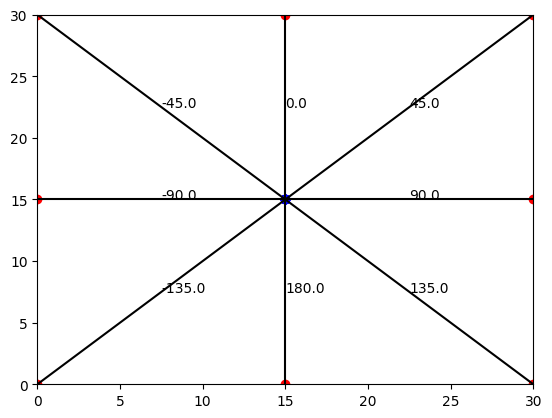

In [19]:
df['obj_vec_0'][2]


pt1s = [(0, 30), (30, 0), (30, 30), (0, 0), (15,30), (30,15), (15,0), (0,15)]
for pt1 in pt1s:
    pt2 = (15, 15)
    ang = np.degrees(np.arctan2(pt1[0] - pt2[0], pt1[1] - pt2[1]))
    # plot the points
    plt.scatter(pt1[0], pt1[1], color='r')
    plt.scatter(pt2[0], pt2[1], color='b')
    # plot the line
    plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='k')
    # plot the angle
    plt.text(0.5*(pt1[0]+pt2[0]), 0.5*(pt1[1]+pt2[1]), str(ang))
plt.xlim(0,30)
plt.ylim(0,30)
plt.show()


Group: ANT, Key: obj_vec_0, p-value: 0.0
Group: ANT, Key: obj_vec_90, p-value: 0.0
Group: ANT, Key: obj_vec_180, p-value: 0.0
Group: ANT, Key: obj_vec_270, p-value: 0.0
Group: NON, Key: obj_vec_0, p-value: 0.0
Group: NON, Key: obj_vec_90, p-value: 0.0
Group: NON, Key: obj_vec_180, p-value: 0.0
Group: NON, Key: obj_vec_270, p-value: 0.0
Group: B6, Key: obj_vec_0, p-value: 0.0
Group: B6, Key: obj_vec_90, p-value: 0.0
Group: B6, Key: obj_vec_180, p-value: 0.0
Group: B6, Key: obj_vec_270, p-value: 0.0


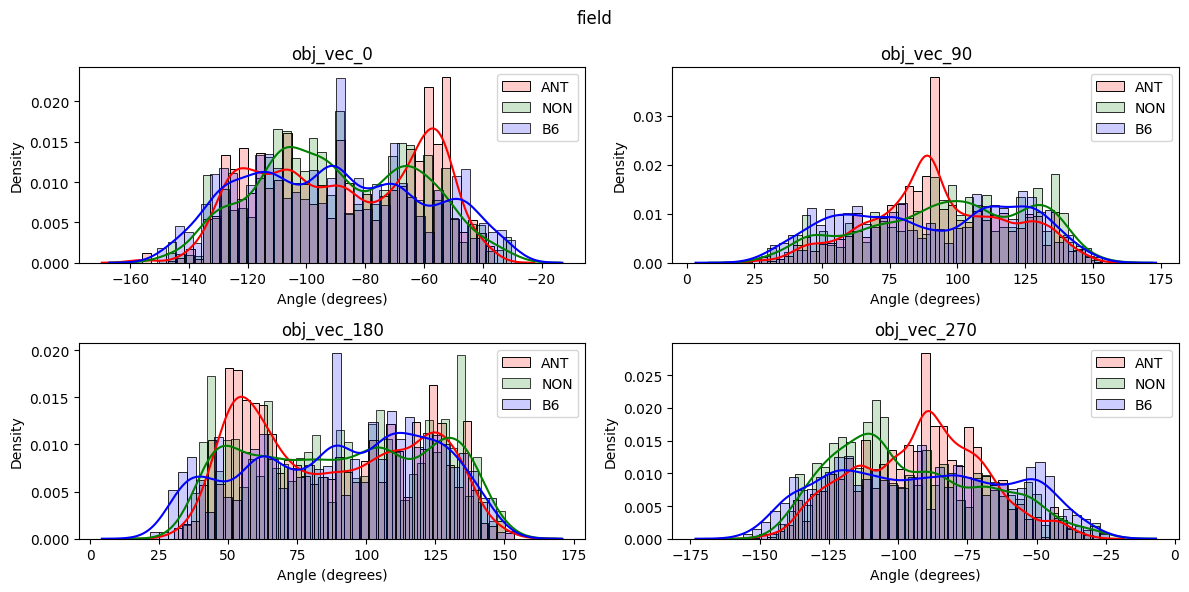

In [20]:
score = 'field'
keys = obj_vec_keys
mag_or_angle = 'angle'
from scipy import stats
import warnings 

warnings.filterwarnings("ignore", category=FutureWarning)
fig = plt.figure(figsize=(12,6))
colors = ['red', 'green', 'blue']

for j in range(1,len(df['group'].unique())+1):
    agg_angs = group_angs[df['group'].unique()[j-1]]
    for i in range(len(keys)):
        to_plot = agg_angs[keys[i]]

        # cts, bins = np.histogram(to_plot, bins=np.arange(0,180,180/30))
        # kde = stats.gaussian_kde(to_plot)

        # mode1 = bins[np.argsort(cts)[-1]]
        # mode2 = bins[np.argsort(cts)[-2]]
        # mode1 = stats.mode(np.abs(to_plot))[0][0]
        # mode2 = stats.mode(np.abs(to_plot))[

        # bimodal coefficient to determine if the distribution is bimodal
        import diptest

        t, p = diptest.diptest(np.asarray(np.abs(to_plot)))

        print('Group: {}, Key: {}, p-value: {}'.format(df['group'].unique()[j-1], keys[i], p))

        ax = plt.subplot(2,2,i+1)
        sns.histplot(to_plot, ax=ax, kde=False, stat='density', bins=40, color=colors[j-1], alpha=0.2, label=df['group'].unique()[j-1])
        sns.kdeplot(to_plot, ax=ax, color=colors[j-1], alpha=1)
        ax.legend()
        ax.set_title(keys[i])
        ax.set_xlabel('Angle (degrees)')
fig.suptitle(score)
fig.tight_layout()
plt.show()

# split by remapping type
# validate if artifact

In [21]:
    import numpy as np
    import diptest

    # generat0e some bimodal random draws
    N = 1000
    hN = N // 2
    x = np.empty(N, dtype=np.float64)
    x[:hN] = np.random.normal(0.4, 1.0, hN)
    x[hN:] = np.random.normal(-0.4, 1.0, hN)

    # only the dip statistic
    dip = diptest.dipstat(x)
    
    # both the dip statistic and p-value
    dip, pval = diptest.diptest(x)

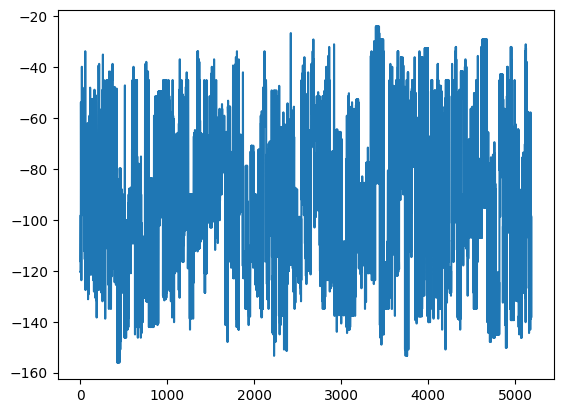

In [22]:
plt.plot(to_plot)

In [23]:
plt.plot(density)

NameError: name 'density' is not defined

In [ ]:
cts

In [ ]:
1

In [ ]:
keys = obj_vec_keys
colors = ['red', 'blue', 'green']

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

for i, key in enumerate(keys):
    ax = axes[i // 2, i % 2]  # Get the appropriate subplot axes
    
    # Prepare the data for box plots
    data = []
    group_names = []
    for group_name in df['group'].unique():
        to_plot = group_angs[group_name][key]
        data.append(to_plot)
        group_names.append(group_name)
    
    # Create the box plots using sns.boxplot
    sns.boxplot(data=data, ax=ax, palette=colors, width=0.4)
    
    ax.set_title(key)
    ax.set_xlabel('Group')
    ax.set_ylabel('Angle (degrees)')

fig.suptitle('Angle')
fig.tight_layout()
plt.show()


In [ ]:
for score in score_keys:
    keys = obj_q_keys
    colors = ['red', 'blue', 'green']

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for i, key in enumerate(keys):
        ax = axes[i // 2, i % 2]  # Get the appropriate subplot axes
        
        # Prepare the data for box plots
        data = []
        group_names = []
        for group_name in df['group'].unique():
            to_plot = df[(df['group'] == group_name) & (df['score'] == score)][key]
            data.append(to_plot)
            group_names.append(group_name)
        
        # Create the box plots using sns.boxplot
        sns.boxplot(data=data, ax=ax, palette=colors, width=0.4)
        
        ax.set_title(key)
        # ax.set_xlabel('Group')
        ax.set_ylabel('Distance')

    fig.suptitle(score)
    fig.tight_layout()
    plt.show()


In [ ]:
df['group'].unique()